# 数值方法

本篇是 *UIUC CS 357 Numerical Methods I* 的学习笔记，会利用 Python 代码协助概念的理解。

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rd

## 目录

## 浮点数与误差

数学计算中我们会频繁用到小数。**定点数（Fixed Point Numbers）** 是计算机中表示小数的一种格式。和我们熟悉的十进制小数不同，计算机只能识别二进制的数据，因此只能使用 0 和 1 来表示一个小数。对于规定了整数部分长度 $n$ 和小数部分长度 $m$ 的 $b$ 进制定点数序列，其值可以通过下面的公式计算。

$$
\begin{equation*}
    (d_{n-1}d_{n-1}...d_0.d_{-1}d_{-2}...d_{-m})_b = \sum_{j=-m}^{n-1} d_jb^j, \quad 0 \le d_j < b
\end{equation*}
$$

举例来说，$10.11$ 就是 $2+0.5+0.25=2.75$。这种方式表示出来的浮点数便于计算，所有数的分布也非常均匀；然而其灵活性很低，表示的小数范围很小（从最小值 $0$ 到 最大值 $b^n-1$，相邻数的间隔为 $2^{-m}$）。虽然我们可以通过扩大 $n$ 和 $m$ 来增加其范围和精度，但其死板的等距分布很多时候不符合我们的需要（试想一下，我们是不是需要在数 $|x| \ll 1$ 时才需要更多精度？当 $|x| \gg 1$ 时我们反而更希望能表示更大的数量级）。

**浮点数（Floating Point Numbers）** 在此需求下诞生了。一个浮点数的实际值通过下面的公式给出：

$$
\begin{equation*}
    x = \pm q\times b^m
\end{equation*}
$$

我们将符号（正或负）、$q$、$m$ 分别的大小固定，就能做到大数的范围大（确保 $m$ 足够长）而小数的精度够（确保 $q$ 足够长）。值得一提的是，$q$ 要求是一个在 $[1.0, 2.0)$ 区间的小数，这是为了防止出现同一个小数可以被两种不同浮点数表示出来的情况（考虑 $q'=2q$, $m'=m-1$ 的情形）。此外，由于 $m$ 可以是一个负数，在设计中可以采用补码的形式，计算公式如下：

$$
    m_km_{k-1}...m_0 = \sum_{j=0}^{k-1} m_jb^j - m_kb^k
$$

其最大值和最小值分别是 $b^k-1$ 和 $-b^k$。下面用 Python 简单呈现一下浮点数的运作机理：

In [2]:
# 辅助函数，将字符变成对应的数字，如 '3' -> 3
def digit(c):
    return ord(c) - ord('0')

# 首先我们先把补码转换函数写出来
## 对于长度为 n 的补码，其第一位的权重为 -2^(n-1)，其它第 j 位的权重为 2^(n-j)
def fp_power(s, base=2):
    n = len(s)
    res = digit(s[0]) * (-base**(n-1))
    for j in range(1, n):
        res += digit(s[j]) * base**(n-j-1)
    return res

# 接下来计算 q 的值，由于第一位只能是 1，我们只需要小数点后面的位
## 对于长度为 n 的输入，其第 j 位的权重为 2^(-j-1)
def fp_digits(s, base=2):
    n = len(s)
    res = 1.0
    for j in range(n):
        res += digit(s[j]) * float(base)**(-j-1)
    return res

# 最后将所有内容结合到一起，一个浮点数由符号位（1 为负数，0 为正数）、指数位（长度为 p）和小数位（长度为 d）组成
def fp_number(s, p, d, base=2):
    sign = s[0] == '1'
    power = fp_power(s[d+1:], base)
    digits = fp_digits(s[1:d+1], base)
    res = digits * float(base)**power
    return -res if sign else res

现在的问题是，对于给定的 $d, p$，我们能精确表示的浮点数有哪些呢？可以先快速给出一些简单的结论：

- 最小的正浮点数是 $2^{-2^{p-1}}$，其出现在小数位取 $1.0$（即后面全是 0），指数位取最小整数 $-2^{p-1}$ 时。
- 最大的正浮点数出现在小数位取 $1.11...1 = 2-2^{-d}$，指数位取最大整数 $2^{p-1}-1$ 时。

下面让我们从最小的正浮点数出发，一步步向前迭代（为了简化表达式，让我们令 $w = -2^{p-1}$，这样指数最大值变为 $-w-1$）：

$$
\begin{align*}
    x_0 &= 1.\underbrace{0...0}_d \times 2^{w} = 2^w\left(1 + \frac{0}{2^d}\right) \\
    x_1 &= 1.\underbrace{0...0}_{d-1}1 \times 2^w = 2^w\left(1 + \frac{1}{2^d}\right) \\
    x_2 &= 1.\underbrace{0...0}_{d-2}10 \times 2^w = 2^w\left(1 + \frac{2}{2^d}\right) \\
    &\dots \\
    x_{2^d-1} &= 1.\underbrace{1...1}_{d} \times 2^w = 2^w\left(1 + \frac{2^d-1}{2^d}\right) \\
    x_{2^d} &= 1.\underbrace{0...0}_d \times 2^{w+1} = 2^{w+1}\left(1 + \frac{0}{2^d}\right) \\
    x_{2^d+1} &= 1.\underbrace{0...0}_{d-1}1 \times 2^{w+1} = 2^{w+1}\left(1 + \frac{1}{2^d}\right) \\
    &\dots \\
    x_{2^{kd}-1} &= 1.\underbrace{1...1}_d \times 2^{w+k-1} = 2^{w+k-1}\left(1 + \frac{2^d-1}{2^d}\right) \\
    x_{2^{kd}} &= 1.\underbrace{0...0}_d \times 2^{w+k} = 2^{w+k}\left(1 + \frac{0}{2^d}\right) \\
    x_{2^{kd}+1} &= 1.\underbrace{0...0}_{d-1}1 \times 2^{w+k} = 2^{w+k}\left(1 + \frac{1}{2^d}\right) \\
    &\dots \\
    x_{2^{(-2w-1)d}-1} &= 1.\underbrace{1...1}_d \times 2^{-w-1} = 2^{-w-1}\left(1 + \frac{2^d-1}{2^d}\right)
\end{align*}
$$

从上面可以找到规律：浮点数呈现的是局部均匀分布的特点。每个局部长度位 $2^d$，一共有 $2^p$ 个。在第 $k$ 个局部中（序号从 0 开始），每两个相邻的数间隔是 $2^{w-d+k}$。因此我们可以写一个 Python 函数计算这个过程：

In [3]:
def fp_number_collect(p, d, base=2):
    w = -base**(p-1)
    res = []
    curr = base**w
    for k in range(-base*w-1):
        inc = float(base)**(w-d+k)
        for j in range(base**d):
            res.append(curr)
            curr += inc
    return res

我们可以以 $p=4$、$d=3$ 为例，打印出所有的正浮点数：

In [4]:
print(fp_number_collect(4, 3), end=', ')

[0.00390625, 0.00439453125, 0.0048828125, 0.00537109375, 0.005859375, 0.00634765625, 0.0068359375, 0.00732421875, 0.0078125, 0.0087890625, 0.009765625, 0.0107421875, 0.01171875, 0.0126953125, 0.013671875, 0.0146484375, 0.015625, 0.017578125, 0.01953125, 0.021484375, 0.0234375, 0.025390625, 0.02734375, 0.029296875, 0.03125, 0.03515625, 0.0390625, 0.04296875, 0.046875, 0.05078125, 0.0546875, 0.05859375, 0.0625, 0.0703125, 0.078125, 0.0859375, 0.09375, 0.1015625, 0.109375, 0.1171875, 0.125, 0.140625, 0.15625, 0.171875, 0.1875, 0.203125, 0.21875, 0.234375, 0.25, 0.28125, 0.3125, 0.34375, 0.375, 0.40625, 0.4375, 0.46875, 0.5, 0.5625, 0.625, 0.6875, 0.75, 0.8125, 0.875, 0.9375, 1.0, 1.125, 1.25, 1.375, 1.5, 1.625, 1.75, 1.875, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 18.0, 20.0, 22.0, 24.0, 26.0, 28.0, 30.0, 32.0, 36.0, 40.0, 44.0, 48.0, 52.0, 56.0, 60.0, 64.0, 72.0, 80.0, 88.0, 96.0, 104.0, 112.0,

这其中就会出现一个有趣的问题：对于给定的浮点数设置，其能够连续表示的整数列有多长呢？在上面的例子中，我们可以看到一直到 16.0 的正整数都可以表示出来，而 17.0 就不存在了。缺漏整数的原因不难猜测，是因为小数位的精细程度不足以细分指数位了。当 $d < 2^{p-1}-1$ 时，我们必然会看到整数缺失的情况，此时最大的整数就是 $2^{d+1}$；相反，最大的整数是 $2^{2^{p-1}-1}-1$。可以用下面的例子证实：

In [5]:
# 先写一个用于验证最大值的辅助函数
def fp_maxintseq(ns):
    last = 0
    for n in ns:
        trunc = int(n)
        if trunc == n:
            if last + 1 == trunc:
                last = trunc
            else:
                return last
    return last

for p in range(3, 6):
    for d in range(1, 2**(p-1)):
        print(f'p={p}, d={d}: {fp_maxintseq(fp_number_collect(p, d))}')

p=3, d=1: 4
p=3, d=2: 7
p=3, d=3: 7
p=4, d=1: 4
p=4, d=2: 8
p=4, d=3: 16
p=4, d=4: 32
p=4, d=5: 64
p=4, d=6: 127
p=4, d=7: 127
p=5, d=1: 4
p=5, d=2: 8
p=5, d=3: 16
p=5, d=4: 32
p=5, d=5: 64
p=5, d=6: 128
p=5, d=7: 256
p=5, d=8: 512
p=5, d=9: 1024
p=5, d=10: 2048
p=5, d=11: 4096
p=5, d=12: 8192
p=5, d=13: 16384
p=5, d=14: 32767
p=5, d=15: 32767


### IEEE 754 标准

本节中将介绍一个浮点数的国际标准，即 IEEE 754，它规定了 **单精度（Single Precision）** 浮点数的标准，其中 $p=8$、$d=23$，加上一个符号位便是 32 位的浮点数。不过出于特殊的考量，其指数位并不是补码，而是源码的形式（但不设符号位），并加上一个位移：

$$
\begin{equation*}
    m = \sum_{j=0}^7 m_j2^j - 127
\end{equation*}
$$

同时要求 $d_j$ 不全为 $0$ 或 $1$（这两种情况有特殊含义）。这让指数在 $[-126, 127]$ 的范围内。举例来说，$67.125$ 可以表示为二进制下的 $1000011.001$，调整小数位后得到 $1.000011001\times2^6$。指数位 $6$ 位移之前应该是 $133 = (10000101)_2$，因此在 IEEE 754 单精度浮点数标准下，这个小数的二进制表示为（下面的空格只是为了方便阅读，并没有实际意义）：

$$
    0\ 10000101\ 000011001\ 00000000000000
$$

同一标准下的 **双精度（Double Precision）** 浮点数有类似的形式，其中 $p=11$、$d=52$，加上一个符号位便是 64 位的浮点数。指数位的位移在这里是 $1023$，即：

$$
    m = \sum_{j=0}^{10} m_j2^j - 1023
$$

类似地，$d_j$ 不能全为 $0$ 或 $1$，此时 $m \in [-1022, 1023]$。

至于被保留的，指数位全为 $0$ 或 $1$ 的情形，标准对其做出了特别定义：

- 若指数位全为 $0$，且小数位也全为 $0$，浮点数的值为 $0$。注意到由于符号位的存在，我们有两种表示数字 $0.0$ 的方式。
- 若指数位全为 $1$，且小数位全为 $0$，浮点数的值根据符号位为 $+\infty$ 或 $-\infty$。
- 若指数位全为 $1$，且小数位不全为 $0$，浮点数的值为 NaN（Not A Number）。

最后一种特殊情况，即指数位全为 $0$，且小数位不全为 $0$，我们将这些数称为 **非规格化浮点数（Subnormal Numbers）**。它们以牺牲精度为代价，能够表示更加小的数据。它的值可以通过下面的公式计算得到：

$$
\begin{equation*}
    x = (-1)^s \times 0.m_{d-1}...m_0\times2^w
\end{equation*}
$$

综上，IEEE 754 标准的浮点数能够表示的最小正数为 $2^{w-d}$，而最小的规格化正数是 $2^w$。对于小于 $2^{w-d}$ 的数，会经历 **向下溢出（Underflow）** 变为 $0$；对于超过最大正数的数，会经历 **向上溢出（Overflow）** 变为 $\infty$。

下面，我们将编写一个通用的浮点数转换函数，其依照 IEEE 标准，能够计算出任意数的二进制形式，也可以反过来讲二进制数据变成小数：

In [6]:
class fp_i3e(object):
    def __init__(self, p, d):
        self._p = p
        self._d = d
        
    @staticmethod
    def _bin2str(x, l=0):
        res = ''
        while x > 0:
            res += '1' if x % 2 == 1 else '0'
            x //= 2
        res += ''.join(['0' for i in range(l-len(res))]) if l > len(res) else ''
        return res[::-1]
    
    @staticmethod
    def _log2(x):
        return int(math.log(x, 2))
        
    @staticmethod
    def _str2bin(s):
        res = 0
        for ch in s:
            res *= 2
            res += digit(ch)
        return res
    
    @property
    def _shift(self):
        return 2**(self._p-1) - 1
    
    def from_str(self, s):
        p, d = self._p, self._d
        sign = s[0] == '1'
        power = fp_i3e._str2bin(s[1:p+1])
        digits = fp_i3e._str2bin(s[p+1:]) * 2**(-d)
        
        # 规格化浮点数，开头会有一个默认的 1
        if power != 0:
            digits += 1
            
        # Infinity 或 NaN
        if power + 1 == 2**p:
            if digits == 0:
                return -math.inf if sign else math.inf
            return math.nan
        else:
            power -= self._shift
            
        res = 2**power * digits
        return -res if sign else res
    
    # BUGS TO FIX
    def to_str(self, x):
        p, d = self._p, self._d
        sign = x < 0
        x = abs(x)
        
        # 规格化浮点数的最小正数和最大正数
        lower_bound = 2**(2-self._shift)
        upper_bound = 2**(self._shift)
        power = 0
        
        if x >= upper_bound:
            return '-Inf' if sign else 'Inf'
        
        if x >= lower_bound:
            power = fp_i3e._log2(x)
            x /= 2**power
            x -= 1
            power += self._shift
        
        s_digits = ''
        for i in range(d):
            curr = 2**(-i-1)
            if x >= curr:
                x -= curr
                s_digits += '1'
            else:
                s_digits += '0'
        return '1' if sign else '0' + self._bin2str(power, p) + s_digits

In [7]:
fp_single = fp_i3e(8, 23)
fp_double = fp_i3e(11, 52)

In [8]:
fp_single.from_str('01000000000001111101111100111011')

2.122999906539917

### 误差

如此前看到的，即使设计得非常精妙，计算机中的浮点数经常会出现 **误差（Error）**。为了更加系统地处理误差，我们需要使用一个通用的误差模型。对于一个值 $x$，其估计值记为 $\hat{x}$（也就是我们计算得到的，有误差的值）。定义 **绝对误差（Absolute Error）** 为两者的差：

$$
\begin{equation*}
    e_a = |x - \hat{x}|
\end{equation*}
$$

不过相比绝对误差本身的大小，很多时候我们更关心这个差距和实际值相比是否足够显著，此时需要定义 **相对误差（Relative Error）**：

$$
\begin{equation*}
    e_r = \frac{|x - \hat{x}|}{|x|}
\end{equation*}
$$

作为例子，$x=2^{-5}$ 和 $\hat{x}=2^{-6}$ 的绝对误差为 $2^{-6}$，但相对误差达到了 $0.5$；$y=2^6$ 和 $\hat{y}=2^5$ 的绝对误差有 $2^5$ 之多，但其相对误差同样也是 $0.5$。

**有效数字（Significant Figures）** 想必我们已经很熟悉了，其描述了一个数值的精确程度。在有误差的语境中，定义 $\hat{x}$ 有 $x$ 的 $n$ 位有效数字，如果它们的绝对误差 $|x - \hat{x}| < 1$ 且在小数点后前 $n-1$ 位均为 $0$，同时第 $n$ 位不超过 $4$。用一个例子可以更清楚地看到其中的含义，令 $x = 3.141592653$：

- 若 $\hat{x} = 3.14159$，此时 $|x - \hat{x}| = 2.653\times10^{-6}$，因此 $\hat{x}$ 有 $x$ 的 6 位有效数字。
- 若 $\hat{x} = 3.1415$，此时 $|x - \hat{x}| = 0.92653\times10^{-4}$，因此 $\hat{x}$ 有 $x$ 的 4 位有效数字。
- 若 $\hat{x} + 3.1416$，此时 $|x - \hat{x}| = 0.7347\times10^{-5}$，因此 $\hat{x}$ 有 $x$ 的 5 位有效数字。

概括来说，估计值在精确值中的有效数字描述了它和精确值的逼近程度。在这个系统下，所有的绝对误差都可以写成下面的形式：

$$
\begin{equation*}
    e_a = |x - \hat{x}| = q\times10^{-n}, \quad 0 \le q < 5
\end{equation*}
$$

相对误差也有类似的形式。令 $x = q\times10^p$、$\hat{x} = \hat{q}\times10^p$（这里 $1 \le q < 10$），则：

$$
\begin{equation*}
    e_r = \frac{|x - \hat{x}|}{|x|} = \frac{|q - \hat{q}|}{|q|} < \frac{5\times10^{-n}}{|q|} < 5\times10^{-n}
\end{equation*}
$$

这样我们就得到了相对错误的上界。出于简便考虑，一个更加常用的上界是 $10^{1-n}$。

现在让我们回到浮点数。一个实数 $x$ 多数情况没法通过二进制序列准确表示（它大概率处在两个可以用机器表示的值（机器值） $x_-$ 和 $x_+$ 中间）。此时我们可以采取的 **取整（Rounding）** 方式有下面几种：

- 切断取整（Round by Chopping）：一是向下取整，即取 $x_-$；对于正数来说是取靠近 0 的最近的机器值，对于负数则是靠近负无穷的最近的机器值。此外也可以向上取整，即取 $x_+$；对于正数来说是取靠近正无穷的最近的机器值，对于负数则是靠近 0 的最近的机器值。
- 靠近取整（Rounding to Nearest）：取使得 $|x_\pm - x|$ 更小的那个机器值。

由取整造成的误差称为 **取整误差（Rounding Error）**。通过计算有：

$$
\begin{equation*}
    e_r = \frac{|x_- - x|}{|x|} \le \frac{\epsilon\times2^m}{q\times2^m} (1 \le q < 2) < \epsilon
\end{equation*}
$$

这里出现的 $\epsilon$ 是一个和 $x$ 大小无关的数，称为 **机器误差（Machine Epsilon）**，其可以通过计算当前浮点数标准中 $1.0$ 和下一个机器值的差得到。在单精度浮点数中有 $\epsilon \approx 1.2\times10^{-7}$，双精度浮点数中则是 $\epsilon \approx 2.2\times10^{-16}$。这样我们就得到了不同精度浮点数标准中相对误差的上界。

下面是 Python 编写的一些辅助函数，和对 `fp_i3e` 类的补充：

In [9]:
def abs_error(exp, obs):
    return abs(exp - obs)

def rel_error(exp, obs):
    return abs(exp - obs) / abs(exp)

@property
def epsilon(self):
    return 2**(-self._d)

fp_i3e.epsilon = epsilon

正是因为取整误差的存在，浮点数的一些操作显得不那么合理。举例来说：

- 结合律不一定生效，即 $(x + y) + z \ne x + (y + z)$ 可能不成立。
- 分配律不一定生效，即 $x(y + z) = xy + xz$ 可能不成立。
- 对一个数加上一个较小的数可能根本没有效果，即 $x + \epsilon = x (\epsilon \ne 0)$ 可能成立。

我们可以直接通过例子证明这些奇怪的现象确实存在：

In [157]:
print((np.pi + 1e100) - 1e100)
print(np.pi + (1e100 - 1e100))
print(100*(0.1 + 0.2) == 100*0.1 + 100*0.2)

0.0
3.141592653589793
False


In [158]:
x = 0.1
# 这个循环永远不会结束
while x < 1e10:
    x += 0.1

KeyboardInterrupt: 

导致上面这样结果的一个重要原因是两个浮点数相减可能会导致精度的缺失。设 $a = 1.a_1a_2...a_{k-1}0a_{k+1}...a_d\times2^m$、$b = 1.a_1a_2...a_{k-1}1a_{k+1}...a_d\times2^m$，此时有：

$$
\begin{equation*}
    b - a = 1.\underbrace{0...0}_{d-k}\times 2^{m-k}
\end{equation*}
$$

这个结果的精度从 $d+1$ 位有效数字降到了 $d-k+1$ 位有效数字，而计算机会贴心地在后面补齐 $k$ 个 0，尽管它们很可能根本不精确。我们对此的解决方式是尝试将原来的算式改为等价的其它形式，新的形式中避免了两个相近浮点数的相减。一个典型的例子是计算 $\sqrt{x^2+1} - 1$。当 $x\to0$ 时显然会遇到问题，但我们可以做一个简单的代数变换：

$$
\begin{equation*}
    \sqrt{x^2+1} - 1 = \frac{(\sqrt{x^2+1} - 1)(\sqrt{x^2+1} + 1)}{\sqrt{x^2+1} + 1} = \frac{x^2}{\sqrt{x^2+1} + 1}
\end{equation*}
$$

可以通过 Python 测试它们的差距：

In [10]:
def foo_original(x):
    return math.sqrt(x**2+1) - 1

def foo_improved(x):
    return x**2 / (math.sqrt(x**2+1) + 1)

print(foo_original(1e-10))
print(foo_improved(1e-10))

0.0
5.0000000000000005e-21


下面让我们再以一个例子展示浮点数可能产生的误差。考虑下面的等式：

$$
\begin{equation*}
    \sum_{n=1}^\infty \frac{1}{n(n+1)} = \sum_{n=1}^\infty \left(\frac{1}{n} - \frac{1}{n+1}\right)
\end{equation*}
$$

可以预见右侧式子会因为 $n$ 的增加造成精度缺失。让我们用 Python 程序展示：

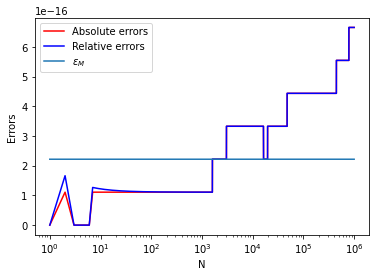

In [90]:
N = 10**6
lhs = np.zeros(N)
rhs = np.zeros(N)
for n in range(1, N):
    lhs[n] = lhs[n-1] + 1/(n*(n+1))
    rhs[n] = rhs[n-1] + (1/n - 1/(n+1))
lhs = np.delete(lhs, 0)
rhs = np.delete(rhs, 0)
abs_errors = np.abs(lhs-rhs)
rel_errors = abs_errors / lhs

Ns = np.arange(1, N)

plt.semilogx(Ns, abs_errors, 'r', label='Absolute errors')
plt.semilogx(Ns, rel_errors, 'b', label='Relative errors')

epsilon_M = np.finfo(float).eps
plt.plot(Ns, [epsilon_M] * (N-1), '-', label='$\epsilon_M$')

plt.legend()
plt.xlabel('N')
plt.ylabel('Errors')

plt.show()

In [87]:
N=10**7
1+(1/N - 1/(N+1))

1.00000000000001

### 泰勒级数

**泰勒级数（Talyor Series）** 是一个常见的用于拟合复杂函数的数学工具。对于一个在 $x_0$ 处多阶可导的函数 $f(x)$，我们可以用幂级数模拟它：

$$
\begin{equation*}
    f(x) = \sum_{k=0}^\infty \frac{f^{(k)}(x_0)}{k!}(x-x_0)^k
\end{equation*}
$$

显然，计算机没有办法计算一个无穷长的公式，我们也不需要无穷的精度，因此通常会指定泰勒级数的 $n$ 阶模拟：

$$
\begin{equation*}
    f(x) = \sum_{k=0}^n \frac{f^{(k)}(x_0)}{k!}(x-x_0)^k
\end{equation*}
$$

通过这种方式导致的误差被称为 **截断误差（Truncation Error）**。根据泰勒级数的完整形式，我们可以给出该误差的解析式：

$$
\begin{align*}
    e_a &= \left| \sum_{k=n+1}^\infty \frac{f^{(k)}(x_0)}{k!}(x - x_0)^k \right|
\end{align*}
$$

现在令 $h = x - x_0$（这里假设 $x > x_0$，反过来的情况是类似的），则必定存在 $\xi \in (x_0, x)$ 使得（根据中值定理，详细的证明这里不表）：

$$
\begin{equation*}
    \frac{f^{(n+1)}(\xi)}{(n+1)!}(\xi - x_0)^{n+1} = R(x) = \sum_{k=n+1}^\infty \frac{f^{(k)}(x_0)}{k!}(x-x_0)^k
\end{equation*}
$$

由于 $\xi - x_0 \le h$，我们有：

$$
\begin{equation*}
    R(x) \le \frac{f^{(n+1)}(\xi)}{(n+1)!}h^{n+1} = Mh^{n+1}
\end{equation*}
$$

这里的 $M$ 是一个常数，可见泰勒级数的截断误差不超过其阶数 +1 的项。

下面让我们以指数函数为例，考察泰勒级数的拟合精确度。回忆在 $x=0$ 处指数函数的泰勒级数为：

$$
\begin{equation*}
    e^x = \sum_{n=0}^\infty \frac{x^n}{n!}
\end{equation*}
$$

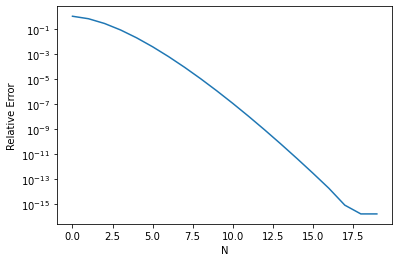

In [35]:
def taylor_exp(x, N):
    res = 0.0
    for n in range(N):
        res += x**n / math.factorial(n)
    return res

# 为了探索 N 取不同值时的准确度，我们跑 20 次求 x=1 的结果
x = 1
N = 20
exp_approx = np.array([taylor_exp(x, n) for n in range(N)])
rel_errors = np.abs(exp_approx - np.e**x) / np.e**x

plt.xlabel('N')
plt.ylabel('Relative Error')
plt.semilogy()
plt.plot([n for n in range(N)], rel_errors)
plot = plt.gca()

可以看到 $N$ 很小的时候就已经有极高的拟合度了。最后曲线变成常数是因为其误差已经小于浮点数处理的极限。不过，泰勒级数的精确度显然也和 $x$ 的取值有关；越靠近中心 $x_0$ 就越准确。下面给出 $N=1$、$N=3$、$N=5$、$N=7$ 时泰勒级数的拟合图像：

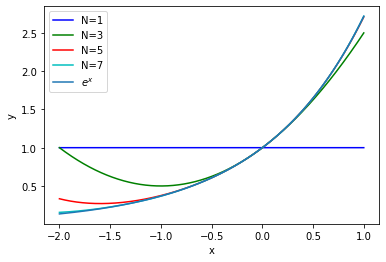

In [134]:
ct = 4
Xs = []
Ys = [[] for i in range(ct)]
Es = []
for x in np.arange(-2.0, 1.0, 1e-3):
    Xs.append(x)
    Es.append(np.e**x)
    for i in range(ct):
        N = 2*i + 1
        Ys[i].append(taylor_exp(x, N))

plt.xlabel('x')
plt.ylabel('y')
colors = ['b', 'g', 'r', 'c', 'm', 'y']
for i in range(ct):
    plt.plot(Xs, Ys[i], colors[i], label=f'N={2*i+1}')
plt.plot(Xs, Es, '-', label=f'$e^x$')
plt.legend()
plot = plt.gca()

可以看到在 $x=0$ 附近时 $N=3, 5, 7$ 都有较好的拟合，直到相差较远时 $N=7$ 才显得格外准确（当然，从数量级来看，它和更大的 $N$ 之间还有差距）

## 随机数

随机数在一些算法中有重要的作用，我们可以通过调用库函数产生*伪随机数*（本篇笔记中我使用的是 `numpy.random` 而非 `random`）：

In [11]:
# 生成一个 [0.0, 1.0) 区间的随机数
print(rd.rand())
# 生成一个给定形状的 numpy.array，每个项都是一个 [0.0, 1.0) 区间的随机数
print(rd.rand(3, 2))

0.09306041340819937
[[0.56476063 0.25560034]
 [0.96344056 0.66017641]
 [0.62849394 0.14547114]]


上面我标记了“伪随机数”这个词，是因为计算机中的随机数是通过算法生成的，因此不可能做到真正的随机。一个简单的随机数生成器可以通过下面的公式实现(线性同余法）：

$$
\begin{equation*}
    x_0 = s, \qquad x_{n+1} = (ax_n + c)\ (\text{mod}\ m)
\end{equation*}
$$

其中 $a, c, m, s$ 都是常数。特别地，我们将 $s$ 称为 **种子值（Seed Value）**。下面用 Python 程序展示它的随机性：

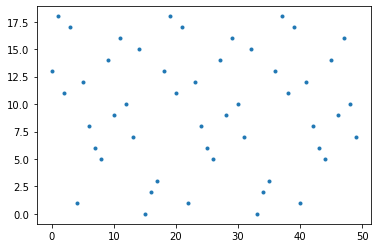

In [12]:
def linear_congruential_gen(a, c, m):
    def feed_seed(s):
        while True:
            s = (a*s + c) % m
            yield s
    return feed_seed

gen_1 = linear_congruential_gen(10, 2, 19)

def display_random(gen, seed, ct):
    xs = []
    r = gen(seed)
    for i in range(ct):
        xs.append(next(r))
    plt.plot(xs, '.')
    
display_random(gen_1, 3, 50)

乍一看，这确实是一个随机的点阵分布；但稍稍仔细观察，就会发现它是三个完全相同的图形拼成的；由于我们选取的 $a$、$c$、$m$ 过于简单，生成器很容易就遍历了所有情况。下面这个生成器或许可以做得更好：

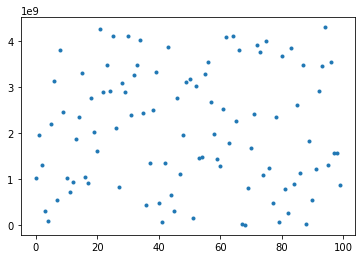

In [13]:
gen_2 = linear_congruential_gen(1664533, 1013904223, 2**32)
display_random(gen_2, 3, 100)

### 随机变量与蒙特卡洛方法

**随机变量（Random Variable）** 是一个将随机过程映射到数值的函数。举例来说，抛硬币后是正面或反面是随机的，我们可以用随机变量表示其结果。因此这种情况下或者有 $X = 1$（正面朝上），否则是 $X = 0$（背面朝上）。尽管随机变量的值是无法确定的，但我们可以计算其 **期望值（Expected Value）**，记作 $E[X]$：

$$
\begin{equation*}
    E[x] = \sum_{i=1}^n p_ix_i
\end{equation*}
$$

其中 $x_i$ 是每个可能的结果对应的数值，而 $0 < p_i < 1$ 是 $x_i$ 出现的概率。硬币的例子中，我们不难得到期望 $0.5$。

**蒙特卡洛方法（Monte Carlo Methods）** 是通过重复随机采样近似某个目标值的算法。还是硬币的例子，我们通过计算只道它的期望是 $0.5$。为了验证这个结果，我们可以进行 $N$ 次实验，然后通过下面的式子计算它的期望值：

$$
\begin{equation*}
    E[x] = \frac{1}{N}\sum_{i=1}^N x_i
\end{equation*}
$$

让我们用 Python 程序模拟这样的实验：

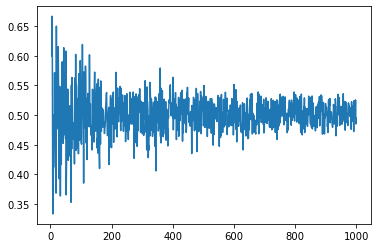

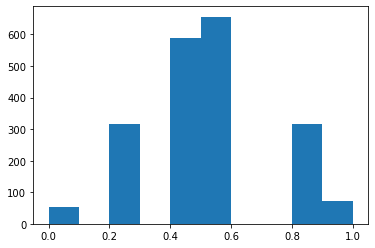

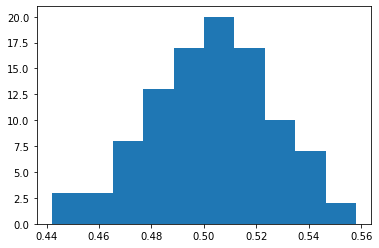

In [217]:
def coin_toss(N):
    xs = []
    for i in range(N):
        xs.append(rd.choice([0, 1]))
    return sum(xs) / N

Ns = []
Es = []
# 我们选取不同的 N，小至 5，大到 1000，观察最后计算得到的期望
for i in range(5, 1000):
    Ns.append(i)
    Es.append(coin_toss(i))
# plt.subplots(1, 3, 1)
plt.plot(Ns, Es)
plt.show()

# 对于结果比较差的 N=5，让我们做 2000 次实验，计算其结果分布
Es = []
for i in range(2000):
    Es.append(coin_toss(5))
# plt.subplots(1, 3, 2)
plt.hist(Es)
plt.show()

# 对于结果比较好的 N=1000，让我们集中做 10 次实验，计算其结果分布
Es = []
for i in range(100):
    Es.append(coin_toss(500))
# plt.subplots(1, 3, 3)
plt.hist(Es)
plt.show()

可以看到，大量的数据支持 $0.5$ 作为期望值，且当我们提高样本大小时，计算得到的期望值会更加稳定于 $0.5$（体现为标准差更加小，可以通过 `Es.std()` 来确认）。

蒙特卡洛的一个重要应用是计算定积分（几何意义便是计算面积和体积的大小）。对于一个复杂的图形，我们可以通过框定包含它的一个简单图形（如正方形），再利用蒙特卡洛计算正方形中随机点落在目标图形内部的概率来推算其面积。让我们以圆形为例：

3.144744


C:\Users\yuyim\AppData\Local\Temp\ipykernel_39440\3711287250.py:28: RuntimeWarning: divide by zero encountered in true_divide
  plt.loglog(Ns, 1/Ns**2, '.')


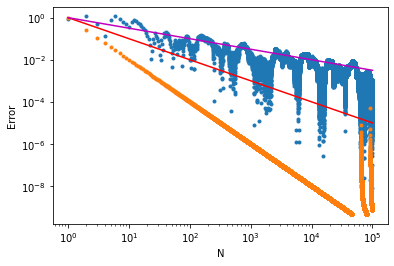

In [239]:
def circle_area(N):
    xs = []
    for i in range(N):
        # 取一个 x: [-1, 1), y: [-1, 1) 的随机点
        x, y = 2 * rd.rand(2) - 1
        # 若落在圆内，则计数
        xs.append(1 if x**2 + y**2 < 1 else 0)
    return sum(xs) / N * 4

print(circle_area(10**6))

# 为了展示精确程度，让我们将 N 从小到大的值对应的统计结果都记录下来
Ns = []
Es = []
xs = []
for i in range(1, 10**5):
    x, y = 2 * rd.rand(2) - 1
    xs.append(1 if x**2 + y**2 < 1 else 0)
    Ns.append(i)
    Es.append(sum(xs) / i * 4)
    
Ns = np.array(Ns)
Es = np.array(Es)

plt.loglog(Ns, np.abs(Es - np.pi), '.')
plt.xlabel('N')
plt.ylabel('Error')
plt.loglog(Ns, 1/Ns**2, '.')
plt.loglog(Ns, 1/Ns, 'r')
plt.loglog(Ns, 1/np.sqrt(Ns), 'm')

可以看到，

In [235]:
np.arange(0, 52)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51])

In [236]:
1

1

In [18]:
x = 1
np.array([sum([np.e**x for i in range(n)]) for n in range(10)])

array([ 0.        ,  2.71828183,  5.43656366,  8.15484549, 10.87312731,
       13.59140914, 16.30969097, 19.0279728 , 21.74625463, 24.46453646])

In [36]:
def simulate_asset_price(N,p0):
    # N: numpber of days
    # p0: initial price 
    # price: 1d numpy array with price fluctuations and shape (N,)
    price = [p0]
    for i in range(1, N):
        price.append(price[i - 1] + step())
#     price = ...
    
    return np.array(price)

In [39]:
np.array(shape=(1, 2))

TypeError: array() got an unexpected keyword argument 'shape'

In [160]:
x = 0.7
y = 0.5
z = 0.4
print(x**2 + np.sin(y) <= z)
print(x - z + np.e**y <= 1)

False
False


In [165]:
np.random.rand(3) * 2

array([0.08728433, 1.77908498, 1.41088176])

In [92]:
1/math.factorial(7)

0.0001984126984126984

In [97]:
1/np.sqrt(2)*(1 + 0.7 - np.pi/4 + 1/2*(0.7 - np.pi/4)**2 - 1/6*(0.7 - np.pi/4)**3)

0.6493729684627799

In [110]:
1e-323

1e-323

In [126]:
a = [[]] * 2
for l in a:
    l.append(114514)
a

[[114514, 114514], [114514, 114514]]

In [166]:
a = [1, 2, 3]
s = set(a)

In [167]:
d = {1: 'ab', 2: 'bc'}
for val in d:
    print(val)

1
2
